<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#pT,-eta" data-toc-modified-id="pT,-eta-1">pT, eta</a></span></li><li><span><a href="#Neutral-energy-fraction" data-toc-modified-id="Neutral-energy-fraction-2">Neutral energy fraction</a></span></li><li><span><a href="#d0-of-tracks-inside-leptonJet-(max,-min)" data-toc-modified-id="d0-of-tracks-inside-leptonJet-(max,-min)-3">d0 of tracks inside leptonJet (max, min)</a></span></li><li><span><a href="#Isolation-(track-,-pfcand-)" data-toc-modified-id="Isolation-(track-,-pfcand-)-4">Isolation (track-, pfcand-)</a></span></li><li><span><a href="#ptDistribution,-dRSpread-(EtaPhiDistribution)" data-toc-modified-id="ptDistribution,-dRSpread-(EtaPhiDistribution)-5">ptDistribution, dRSpread (EtaPhiDistribution)</a></span></li><li><span><a href="#[jetsub]-$\lambda,-\epsilon$-|-pT,energy-distribution" data-toc-modified-id="[jetsub]-$\lambda,-\epsilon$-|-pT,energy-distribution-6">[jetsub] $\lambda, \epsilon$ | pT,energy distribution</a></span></li><li><span><a href="#[jetsub]-Energy-correlation-function-variables-{e1,-e2,-e3}" data-toc-modified-id="[jetsub]-Energy-correlation-function-variables-{e1,-e2,-e3}-7">[jetsub] Energy correlation function variables {e1, e2, e3}</a></span><ul class="toc-item"><li><span><a href="#Testing-area" data-toc-modified-id="Testing-area-7.1">Testing area</a></span></li></ul></li></ul></div>

Locate promising variables to discrimnate matched signals to misreconstructed backgrounds.

Plots contain 4 categories (All normalized):
+ 4mu(matched, unmatched)
+ 2mu2e(matched, unmatched)
- - - 

**variables summary**
1. pT
2. eta
3. neutral energy fraction
4. maxd0
5. mind0
6. tkIso
7. pfIso
8. pT distribution
9. etaPhi distribution
10. substructure momentum distribution
11. substructure energy distribution
12. ECF e1
13. ECF e2
14. ECF e3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from uproot_methods import TLorentzVectorArray
from awkward import JaggedArray
from histbook import *

import utils.uprootHelpers as uuh
import utils.commonHelpers as uch
import utils.histoHelpers as uhh
from utils.SignalDescription import SignalDescription

plt.style.use('default')
plt.rcParams.update(uhh.ffPltStyleSettings)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sd = SignalDescription()
sig4mu = sd.files('4mu', grouped=True, nth=-1)
sig2mu2e = sd.files('2mu2e', grouped=True, nth=-1)

sigfs4mu   = [f for x in sig4mu.values() for f in x]
sigfs2mu2e = [f for x in sig2mu2e.values() for f in x]

### pT, eta

In [3]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        self['lj_m'] = lambda: jetp4[jetMatchIdx][self.mHLT]
        self['lj_u'] = lambda: jetp4[jetUnmatchedMask][self.mHLT]

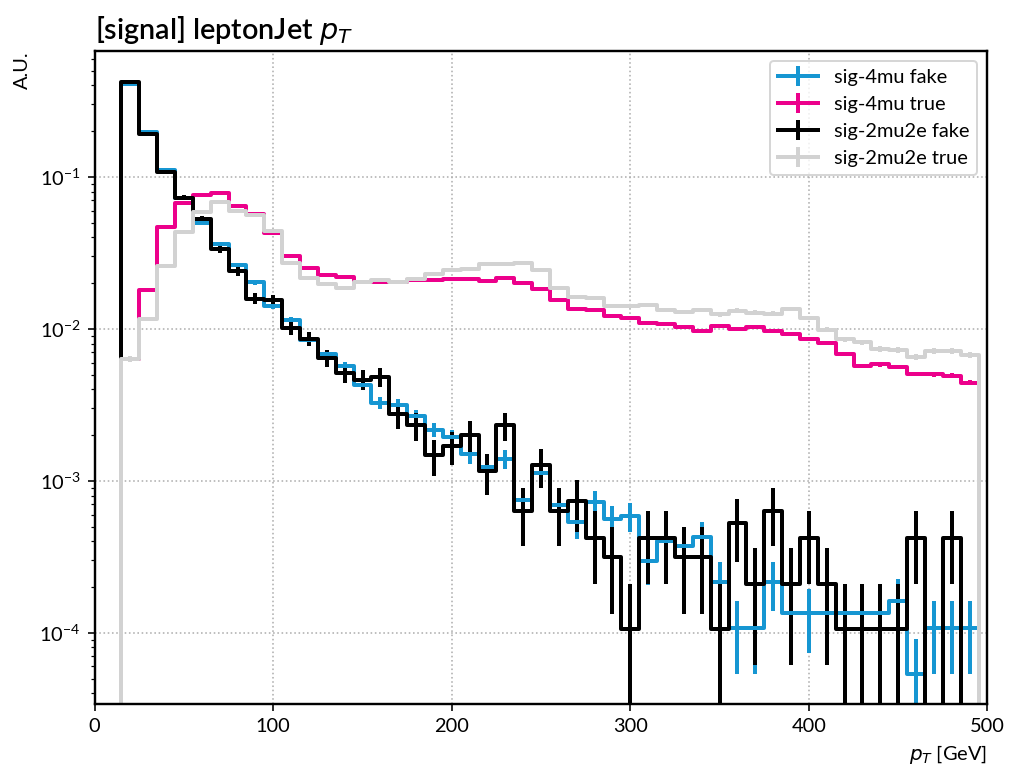

In [5]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def fillpt(d): return d.pt.flatten()

hPt = Hist(bin('x', 50, 0, 500))
hs['sig-4mu fake'  ] = uhh.MultiFill(hPt, loaded, 'lj_u', fillpt, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hPt, loaded, 'lj_m', fillpt, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hPt, loaded, 'lj_u', fillpt, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hPt, loaded, 'lj_m', fillpt, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
#     norm=False,
    xlabel='$p_T$ [GeV]',
    ylabel='A.U.',
    title='[signal] leptonJet $p_T$'
)
fig.savefig('imgs/signal-leptonjet-pt.pdf', bbox_inches='tight');

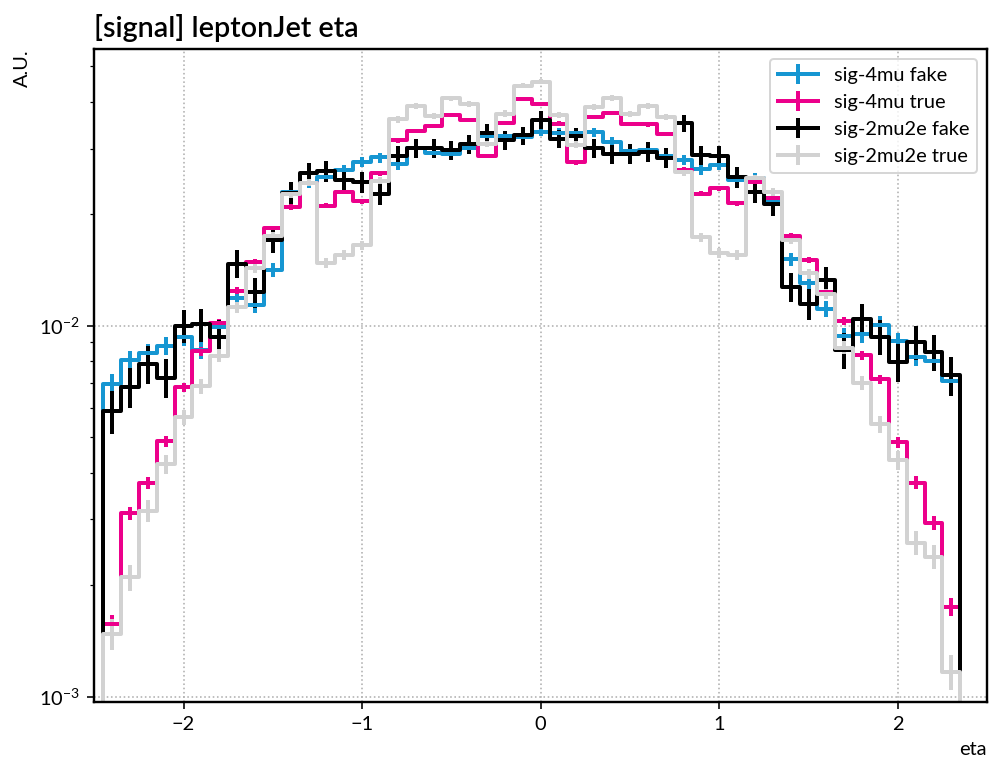

In [13]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def filleta(d): return d.eta.flatten()

hEta = Hist(bin('x', 50, -2.5, 2.5))
hs['sig-4mu fake'  ] = uhh.MultiFill(hEta, loaded, 'lj_u', filleta, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hEta, loaded, 'lj_m', filleta, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hEta, loaded, 'lj_u', filleta, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hEta, loaded, 'lj_m', filleta, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='eta',
    ylabel='A.U.',
    title='[signal] leptonJet eta'
)
fig.savefig('imgs/signal-leptonjet-eta.pdf', bbox_inches='tight');

### Neutral energy fraction

In [14]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        neutralEnergyFrac = lambda: (
            t['pfjet_neutralEmE'].array()
            +t['pfjet_neutralHadronE'].array()
        )/jetp4.energy
        
        self['neufrac_u'] = lambda: neutralEnergyFrac()[jetUnmatchedMask][self.mHLT]
        self['neufrac_m'] = lambda: neutralEnergyFrac()[jetMatchIdx][self.mHLT]

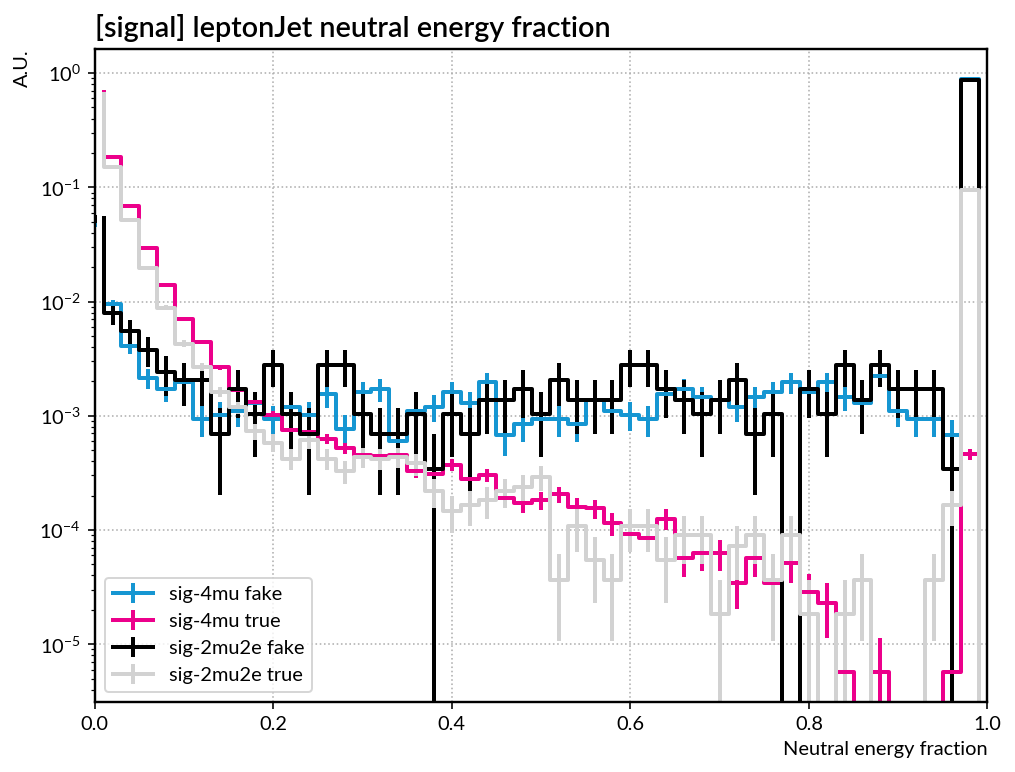

In [15]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def doFill(d): return d.flatten()

hFrac = Hist(bin('x', 50, 0, 1))
hs['sig-4mu fake'  ] = uhh.MultiFill(hFrac, loaded, 'neufrac_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hFrac, loaded, 'neufrac_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hFrac, loaded, 'neufrac_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hFrac, loaded, 'neufrac_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='Neutral energy fraction',
    ylabel='A.U.',
    title='[signal] leptonJet neutral energy fraction'
)
fig.savefig('imgs/signal-leptonjet-nef.pdf', bbox_inches='tight');

### d0 of tracks inside leptonJet (max, min)

In [3]:
def pickExtreme(ja, maxmin):
    if ja.size == 0:
        return np.array([])
    if maxmin == "max":
        return np.array([max(x) if x.size else np.nan for x in ja])
    if maxmin == "min":
        return np.array([min(x) if x.size else np.nan for x in ja])
    return np.array([])

class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        candTkd0 = lambda: uuh.NestNestObjArrayToJagged(t['pfjet_pfcand_tkD0'].array())
        self['maxd0_u'] = lambda: pickExtreme(candTkd0()[jetUnmatchedMask][self.mHLT].flatten(), 'max')
        self['maxd0_m'] = lambda: pickExtreme(candTkd0()[jetMatchIdx][self.mHLT].flatten(), 'max')
        self['mind0_u'] = lambda: pickExtreme(candTkd0()[jetUnmatchedMask][self.mHLT].flatten(), 'min')
        self['mind0_m'] = lambda: pickExtreme(candTkd0()[jetMatchIdx][self.mHLT].flatten(), 'min')

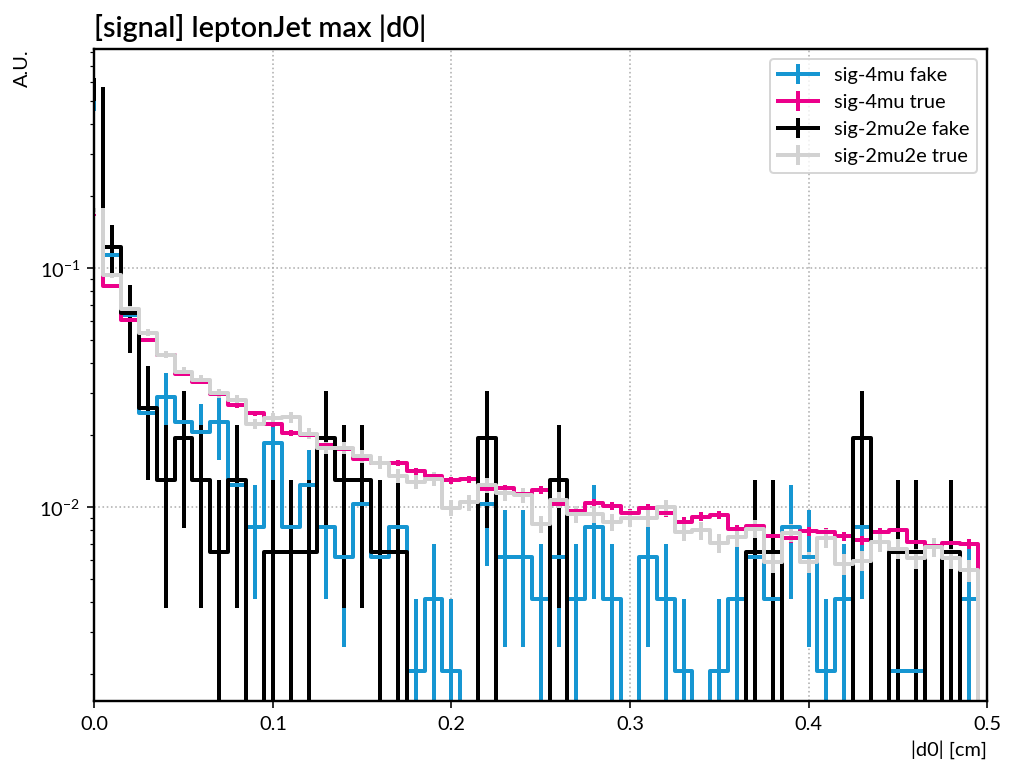

In [4]:
hs = dict()
def doFill(d): return d
fig, ax = plt.subplots(figsize=(8,6))
hD0 = Hist(bin('x', 50, 0, 0.5))

hs['sig-4mu fake'  ] = uhh.MultiFill(hD0, loaded, 'maxd0_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hD0, loaded, 'maxd0_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hD0, loaded, 'maxd0_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hD0, loaded, 'maxd0_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='|d0| [cm]',
    ylabel='A.U.',
    title='[signal] leptonJet max |d0|'
)
fig.savefig('imgs/signal-leptonjet-maxd0.pdf', bbox_inches='tight');

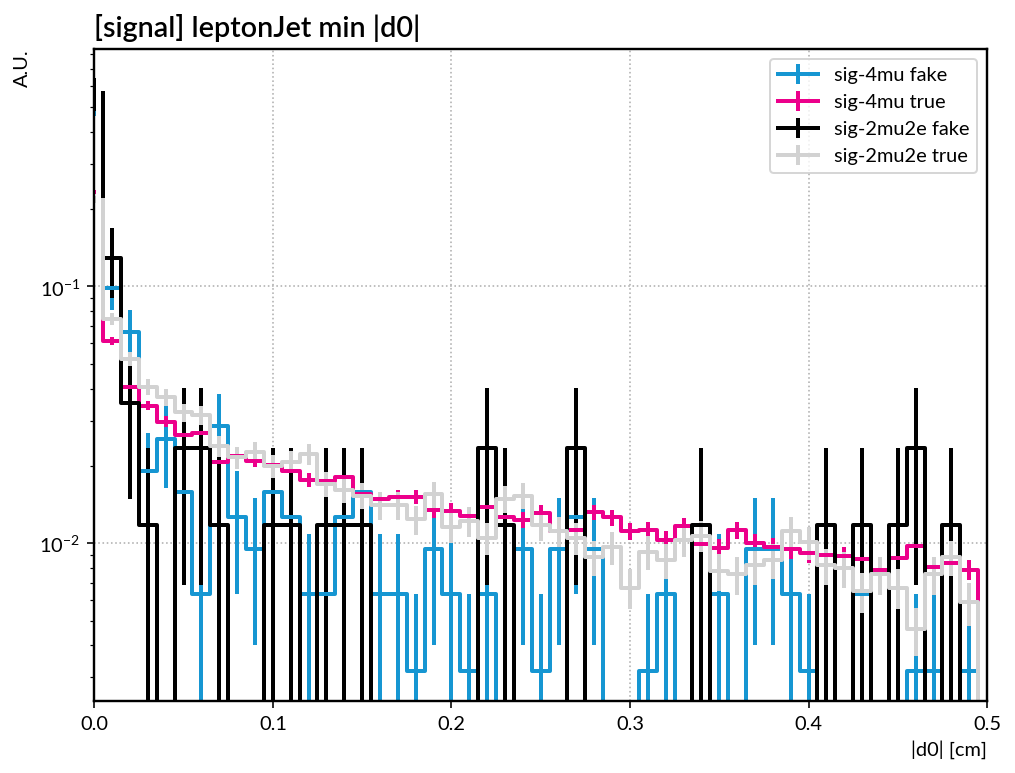

In [5]:
hs = dict()
def doFill(d): return d
fig, ax = plt.subplots(figsize=(8,6))
hD0 = Hist(bin('x', 50, 0, 0.5))

hs['sig-4mu fake'  ] = uhh.MultiFill(hD0, loaded, 'mind0_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hD0, loaded, 'mind0_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hD0, loaded, 'mind0_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hD0, loaded, 'mind0_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='|d0| [cm]',
    ylabel='A.U.',
    title='[signal] leptonJet min |d0|'
)
fig.savefig('imgs/signal-leptonjet-mind0.pdf', bbox_inches='tight');

### Isolation (track-, pfcand-)

In [6]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        self['tkiso_u'] = lambda: self.tree['pfjet_tkIsolation05'].array()[jetUnmatchedMask][self.mHLT]
        self['tkiso_m'] = lambda: self.tree['pfjet_tkIsolation05'].array()[jetMatchIdx][self.mHLT]
        self['pfiso_u'] = lambda: self.tree['pfjet_pfIsolation05'].array()[jetUnmatchedMask][self.mHLT]
        self['pfiso_m'] = lambda: self.tree['pfjet_pfIsolation05'].array()[jetMatchIdx][self.mHLT]

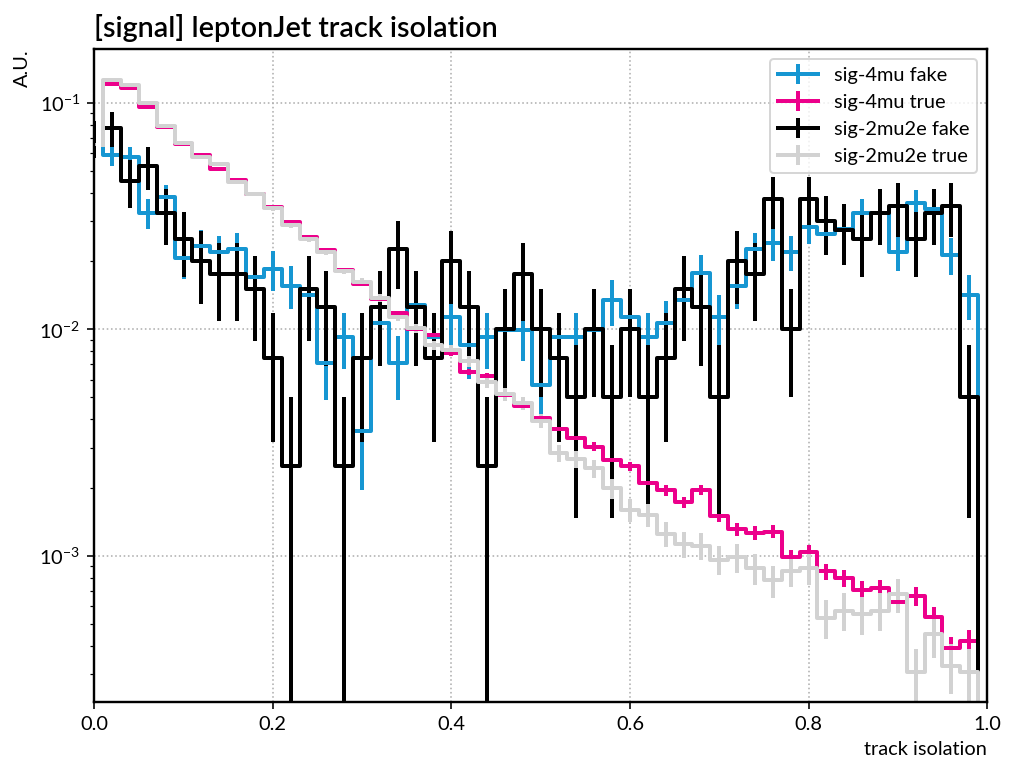

In [7]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hIso = Hist(bin('x', 50, 0, 1))

hs['sig-4mu fake'  ] = uhh.MultiFill(hIso, loaded, 'tkiso_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hIso, loaded, 'tkiso_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hIso, loaded, 'tkiso_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hIso, loaded, 'tkiso_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='track isolation',
    ylabel='A.U.',
    title='[signal] leptonJet track isolation'
)
fig.savefig('imgs/signal-leptonjet-tkiso.pdf', bbox_inches='tight');

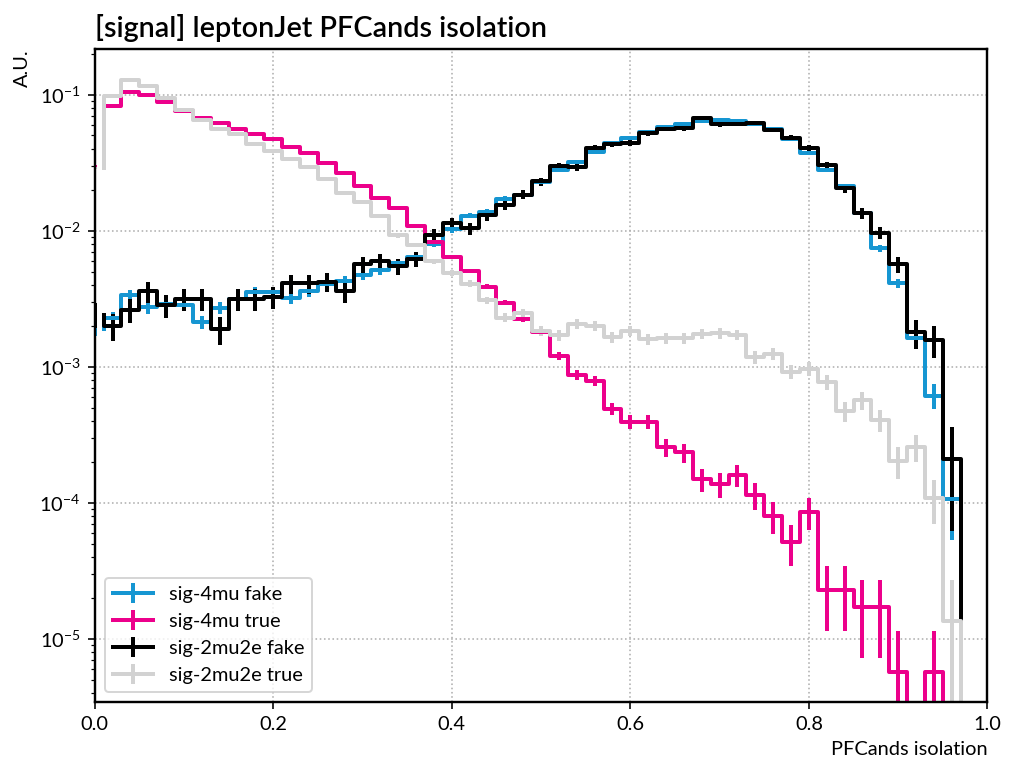

In [8]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hIso = Hist(bin('x', 50, 0, 1))

hs['sig-4mu fake'  ] = uhh.MultiFill(hIso, loaded, 'pfiso_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hIso, loaded, 'pfiso_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hIso, loaded, 'pfiso_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hIso, loaded, 'pfiso_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='PFCands isolation',
    ylabel='A.U.',
    title='[signal] leptonJet PFCands isolation'
)
fig.savefig('imgs/signal-leptonjet-pfiso.pdf', bbox_inches='tight');

### ptDistribution, dRSpread (EtaPhiDistribution)

In [9]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        self['ptdist_u'] = lambda: t['pfjet_ptDistribution'].array()[jetUnmatchedMask][self.mHLT]
        self['ptdist_m'] = lambda: t['pfjet_ptDistribution'].array()[jetMatchIdx][self.mHLT]
        self['drspread_u'] = lambda: t['pfjet_dRSpread'].array()[jetUnmatchedMask][self.mHLT]
        self['drspread_m'] = lambda: t['pfjet_dRSpread'].array()[jetMatchIdx][self.mHLT]

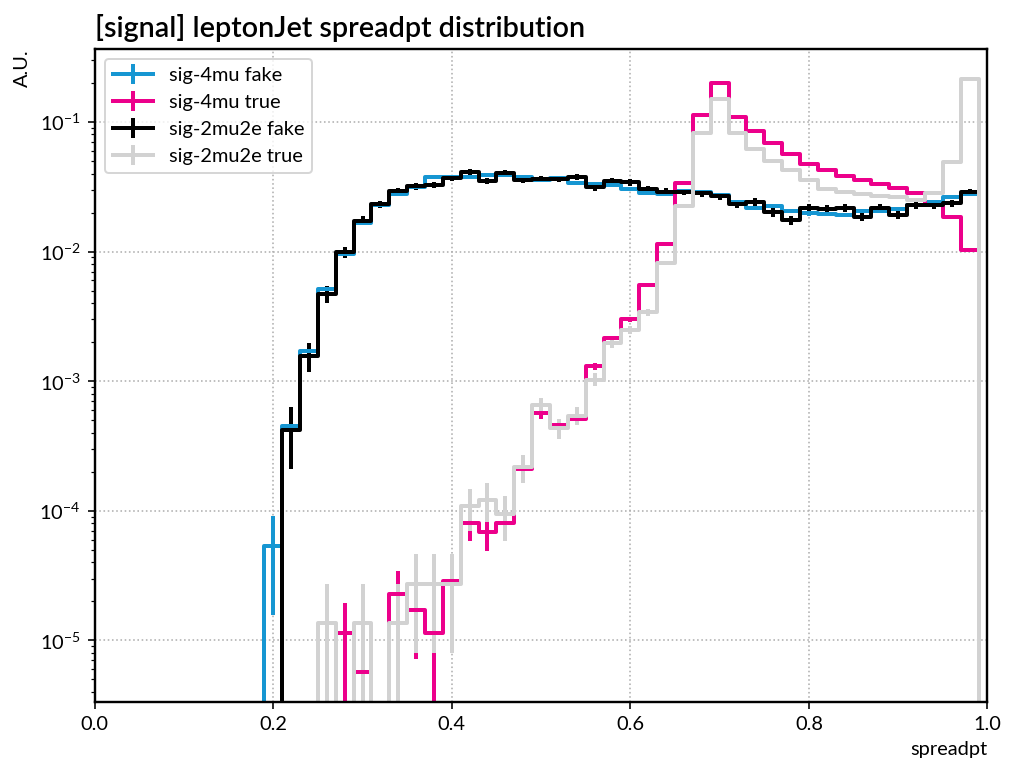

In [10]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hPtd = Hist(bin('x', 50, 0, 1))

hs['sig-4mu fake'  ] = uhh.MultiFill(hPtd, loaded, 'ptdist_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hPtd, loaded, 'ptdist_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hPtd, loaded, 'ptdist_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hPtd, loaded, 'ptdist_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='spreadpt',
    ylabel='A.U.',
    title='[signal] leptonJet spreadpt distribution'
)
fig.savefig('imgs/signal-leptonjet-spreadpt.pdf', bbox_inches='tight');

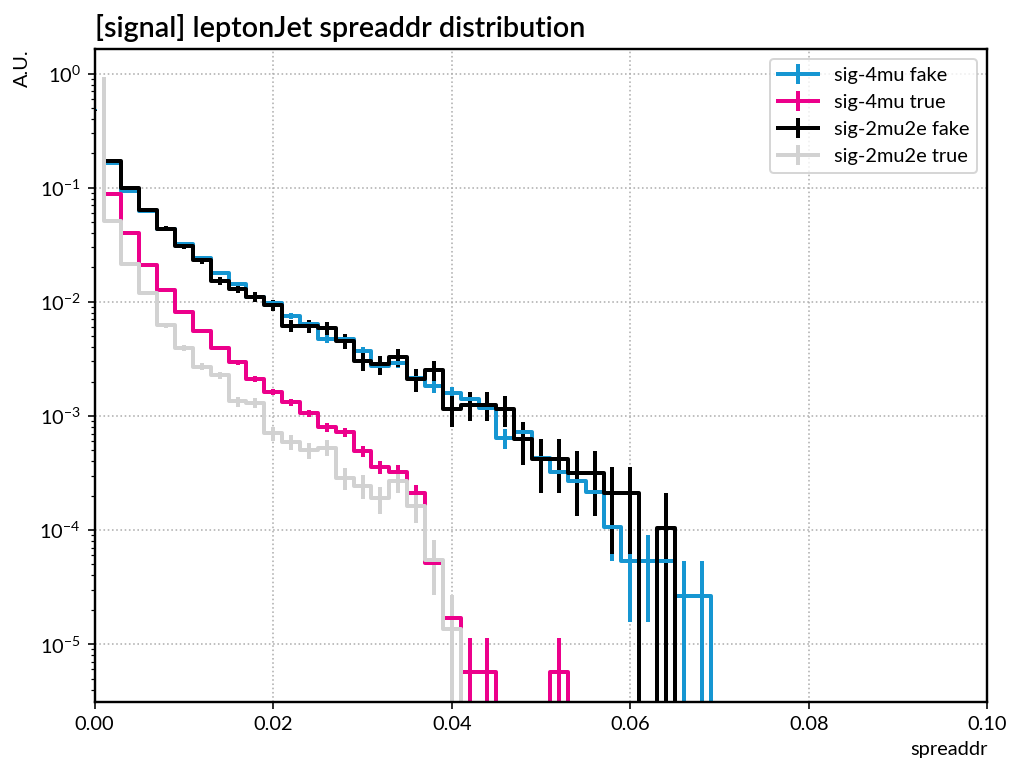

In [11]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hPtd = Hist(bin('x', 50, 0, 0.1))

hs['sig-4mu fake'  ] = uhh.MultiFill(hPtd, loaded, 'drspread_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hPtd, loaded, 'drspread_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hPtd, loaded, 'drspread_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hPtd, loaded, 'drspread_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='spreaddr',
    ylabel='A.U.',
    title='[signal] leptonJet spreaddr distribution'
)
fig.savefig('imgs/signal-leptonjet-spreaddr.pdf', bbox_inches='tight');

### [jetsub] $\lambda, \epsilon$ | pT,energy distribution

In [12]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        self['lambda_u'] = lambda: t['pfjet_subjet_lambda'].array()[jetUnmatchedMask][self.mHLT]
        self['lambda_m'] = lambda: t['pfjet_subjet_lambda'].array()[jetMatchIdx][self.mHLT]
        self['epsilon_u'] = lambda: t['pfjet_subjet_epsilon'].array()[jetUnmatchedMask][self.mHLT]
        self['epsilon_m'] = lambda: t['pfjet_subjet_epsilon'].array()[jetMatchIdx][self.mHLT]

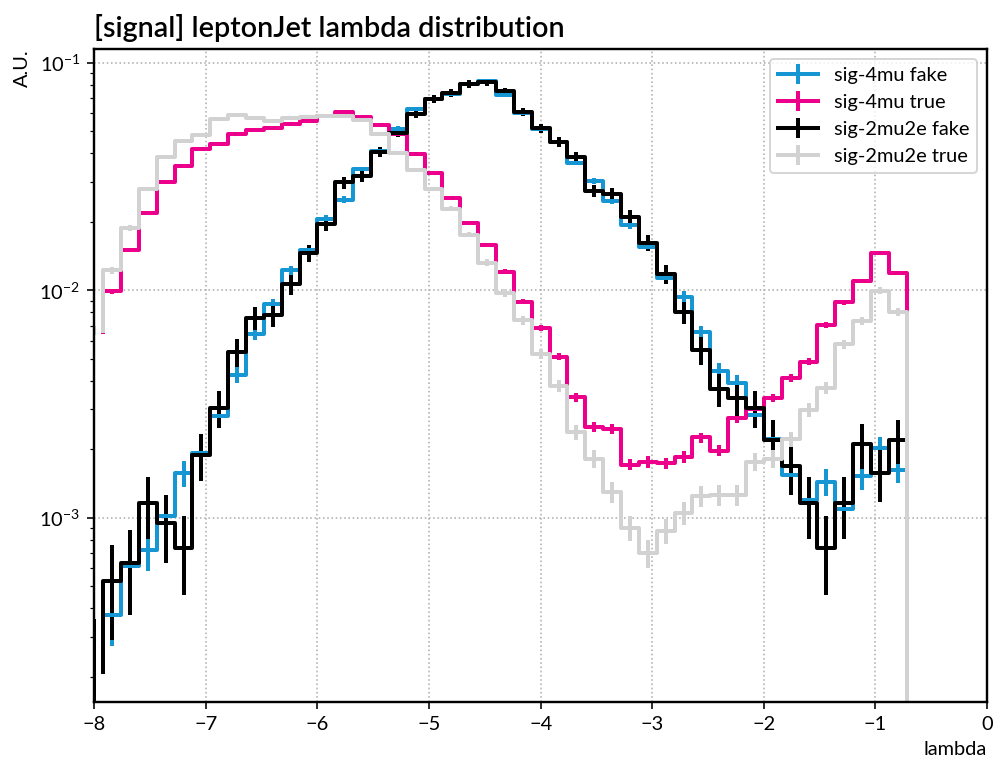

In [13]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, -8, 0))

hs['sig-4mu fake'  ] = uhh.MultiFill(hDist, loaded, 'lambda_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hDist, loaded, 'lambda_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hDist, loaded, 'lambda_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hDist, loaded, 'lambda_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='lambda',
    ylabel='A.U.',
    title='[signal] leptonJet lambda distribution'
)
fig.savefig('imgs/signal-leptonjet-lambda.pdf', bbox_inches='tight');

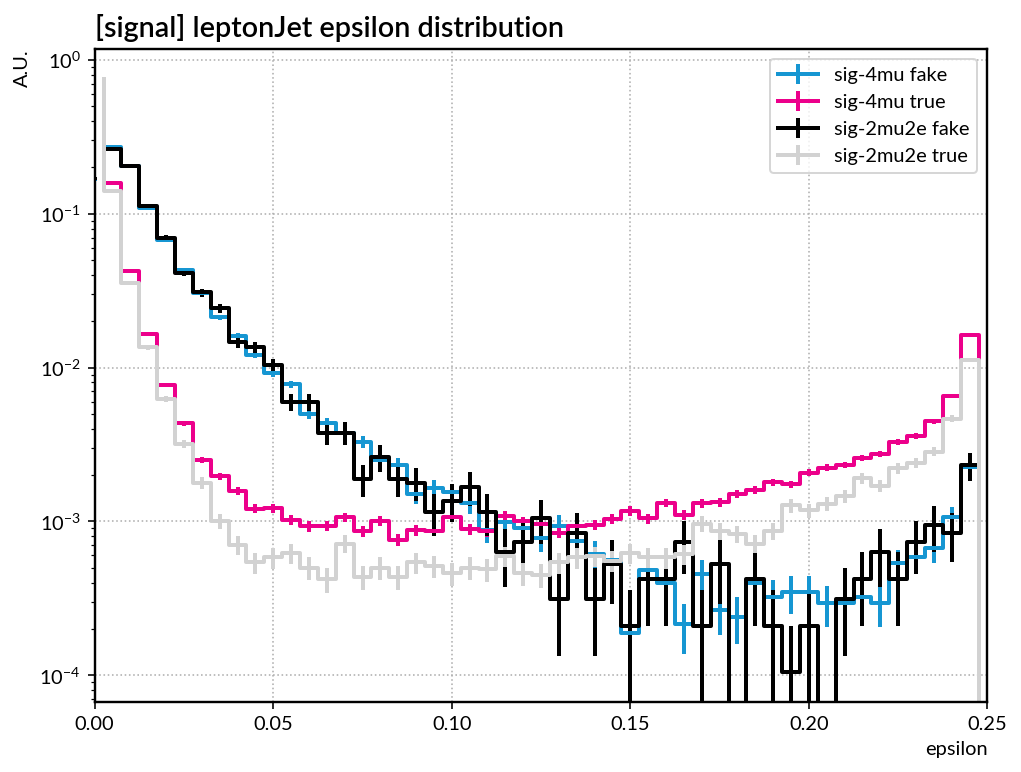

In [14]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 0.25))

hs['sig-4mu fake'  ] = uhh.MultiFill(hDist, loaded, 'epsilon_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hDist, loaded, 'epsilon_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hDist, loaded, 'epsilon_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hDist, loaded, 'epsilon_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='epsilon',
    ylabel='A.U.',
    title='[signal] leptonJet epsilon distribution'
)
fig.savefig('imgs/signal-leptonjet-epsilon.pdf', bbox_inches='tight');

### [jetsub] Energy correlation function variables {e1, e2, e3}

In [15]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        genp4 = uuh.p4Array(t['gen_p4'])
        mDarkPhoton = t['gen_pid'].array()==32
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        genMatchIdx, jetMatchIdx = uuh.IndexArraysFromMatching(genp4[mDarkPhoton], jetp4)
        jetUnmatchedMask = ~uuh.MaskArrayFromIndexArray(jetMatchIdx, jetp4)
        
        self['e1_u'] = lambda: t['pfjet_subjet_ecf1'].array()[jetUnmatchedMask][self.mHLT]
        self['e1_m'] = lambda: t['pfjet_subjet_ecf1'].array()[jetMatchIdx][self.mHLT]
        self['e2_u'] = lambda: t['pfjet_subjet_ecf2'].array()[jetUnmatchedMask][self.mHLT]
        self['e2_m'] = lambda: t['pfjet_subjet_ecf2'].array()[jetMatchIdx][self.mHLT]
        self['e3_u'] = lambda: t['pfjet_subjet_ecf3'].array()[jetUnmatchedMask][self.mHLT]
        self['e3_m'] = lambda: t['pfjet_subjet_ecf3'].array()[jetMatchIdx][self.mHLT]

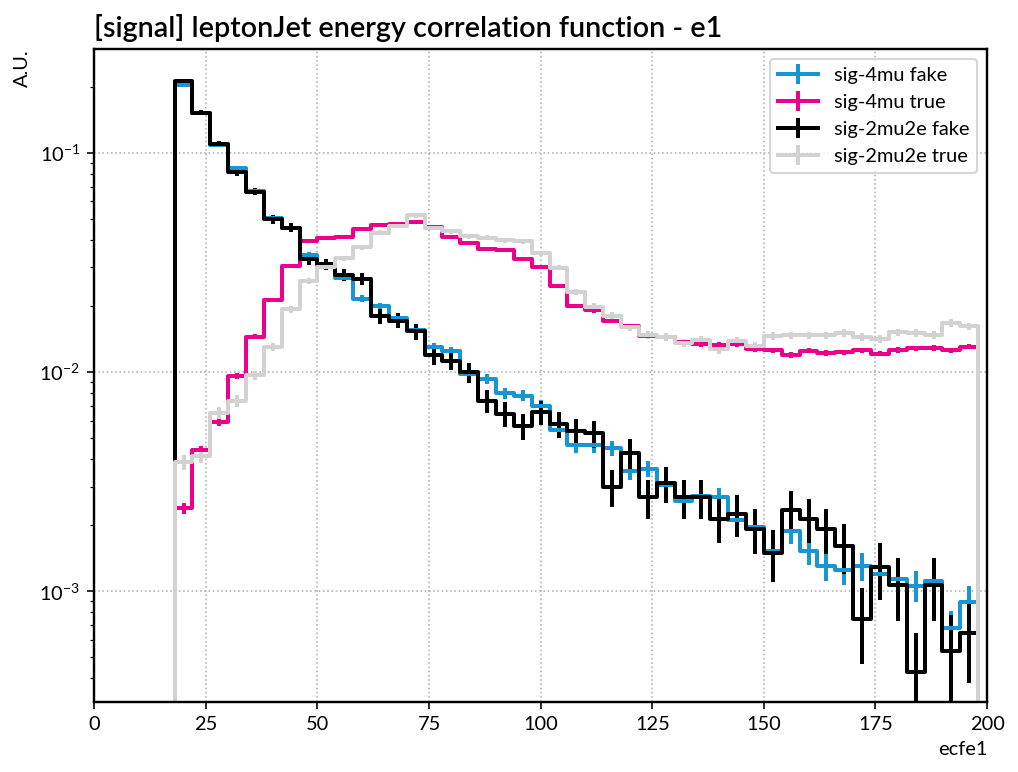

In [16]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 200))

hs['sig-4mu fake'  ] = uhh.MultiFill(hDist, loaded, 'e1_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hDist, loaded, 'e1_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hDist, loaded, 'e1_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hDist, loaded, 'e1_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe1',
    ylabel='A.U.',
    title='[signal] leptonJet energy correlation function - e1'
)
fig.savefig('imgs/signal-leptonjet-ecfe1.pdf', bbox_inches='tight');

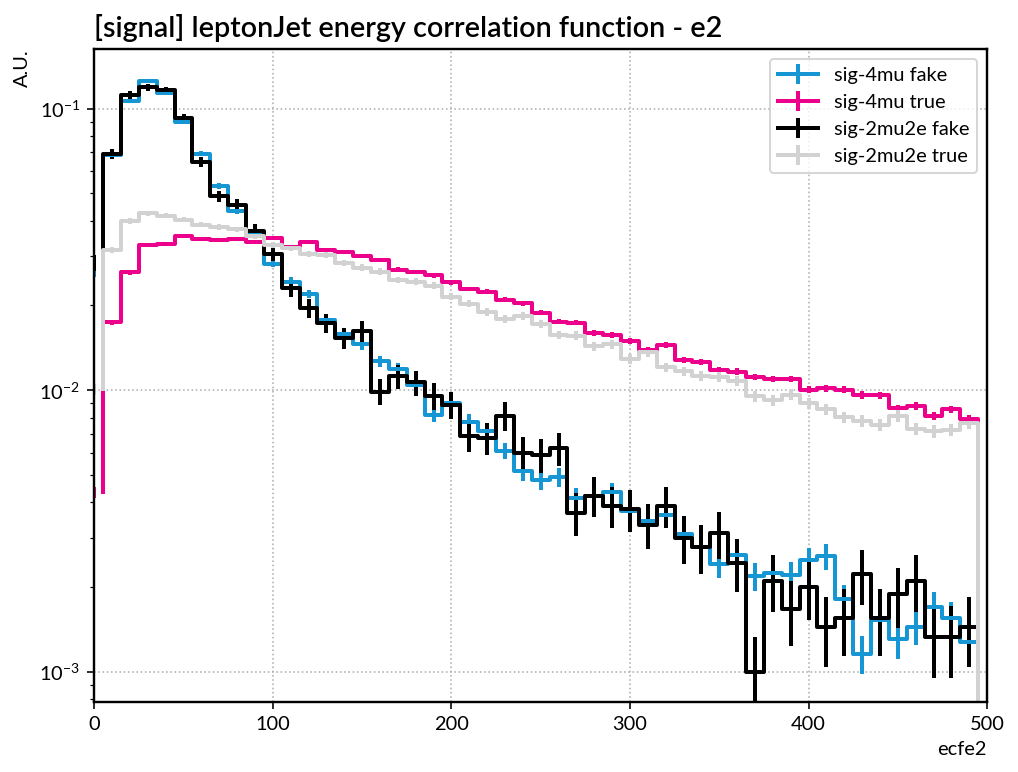

In [17]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 500))

hs['sig-4mu fake'  ] = uhh.MultiFill(hDist, loaded, 'e2_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hDist, loaded, 'e2_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hDist, loaded, 'e2_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hDist, loaded, 'e2_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe2',
    ylabel='A.U.',
    title='[signal] leptonJet energy correlation function - e2'
)
fig.savefig('imgs/signal-leptonjet-ecfe2.pdf', bbox_inches='tight');

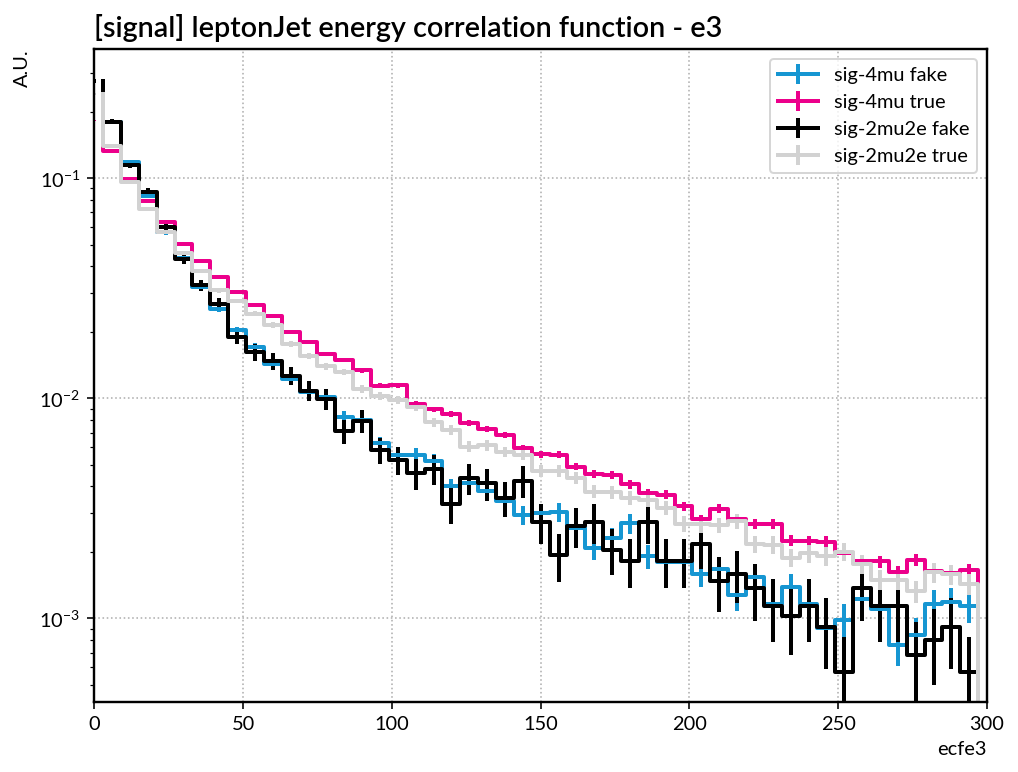

In [18]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 300))

hs['sig-4mu fake'  ] = uhh.MultiFill(hDist, loaded, 'e3_u', doFill, sigfs4mu)
hs['sig-4mu true'  ] = uhh.MultiFill(hDist, loaded, 'e3_m', doFill, sigfs4mu)
hs['sig-2mu2e fake'] = uhh.MultiFill(hDist, loaded, 'e3_u', doFill, sigfs2mu2e)
hs['sig-2mu2e true'] = uhh.MultiFill(hDist, loaded, 'e3_m', doFill, sigfs2mu2e)

uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe3',
    ylabel='A.U.',
    title='[signal] leptonJet energy correlation function - e3'
)
fig.savefig('imgs/signal-leptonjet-ecfe3.pdf', bbox_inches='tight');

----
#### Testing area